# Predicting the Popularity of a Book on Project Gutenberg

#### William Shearer

## Introduction
We are currently facing a difficult time in the world with the coronavirus and all the issues that surround it. In this time we turn to entertainment and things to preserve our mental health and help us stay inside. Many people are tired of sitting on the couch all day and watching Netflix and have transitioned to sitting on the couch all day and reading books.

Books don't tend to be free and people tend to buy physical copies at physical stores. Both of these are an issue when the pandemic is causing financial instability and making visiting an in person store difficult. [Project gutenberg](https://en.wikipedia.org/wiki/Project_Gutenberg) offers a solution to this. The brainchild of Micheal S. Hart, project gutenberg is a huge and well known online center storing tens of thousands of books in the public domain that are free for anyone to download. This means that users can access books for free and without leaving quarantine, increasing accessibility.

Project gutenberg can't have all the books from the public domain added to it at once. There is a lot of processing that goes into making a book accessible across platforms and storage space isn't free. This brings up the question, how can we determine the best books to add to project gutenberg and in what order? We need to create a function for this, we'll use goodreads data as our input.

Goodreads is a website where people go to rate and review books and it is massive, with reviews of millions of books. For this project we will use [this](https://www.kaggle.com/jealousleopard/goodreadsbooks) kaggle dataset by user soumik. This dataset is the largest and and most up to date one that queries the goodreads API.

In this tutorial we will try and find the answer to the question of if we can use the popularity of books in the public domain on goodreads to predict what books will do well on project gutenberg. This means that we will have a null hypothesis that there is no relation between the popularity of books on goodreads and the popularity of books on project gutenberg and an alternative hypothesis that there is a positive relationship between the popularity of books on the two databases.


# Data Collection
We will be using web-scraping as well as reading in csv files to access the data we will be using.

In [1]:
#I am running a docker container that does not have lxml or html5lib installed, you can install these on 
#your machine without dealing with a system import in the code
import sys
!{sys.executable} -m pip install lxml html5lib

     |████████████████████████████████| 5.4 MB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 2.5 MB/s eta 0:00:01


In [2]:
import requests
from bs4 import BeautifulSoup, NavigableString, Tag
import pandas as pd
import numpy as np
import re #regex
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Scraping Project Gutenberg
The first set of data we are going to gather is the top 100 books on project gutenberg over the last 30 days. To do this we will scrape their website using a [HTTP GET request](https://www.datacamp.com/community/tutorials/making-http-requests-in-python) combined with a User-Agent in the header. Every browser-OS combination will have a different User-Agent so here is a [list](https://www.whatismybrowser.com/guides/the-latest-user-agent/) to find yours. When performing a GET request check the status code is '200' which means a successful request. 

In [3]:
url = str('https://www.gutenberg.org/browse/scores/top#books-last30')
headers = {'User-Agent':'Mozilla/5.0 (x11; Ubuntu; Linux x86_64; rv:80.0) Gecko/20100101 Firefox/80.0'}
r = requests.get(url, headers=headers)
print(r.status_code)
soup = BeautifulSoup(r.content, 'html')
#You can use prettify() to look through the html of the site
#soup.prettify()

200


We've read in the project gutenberg webpage, now it's time to find the data pertaining to the top 100 books in the last 30 days. It can be helpful to use beautifulsoup's prettify() along with the "inspect element" function of your web-browser to find exactly where this data is.

In [4]:
#The data we want is in an ordered list HTML element
g = soup.findAll('ol')
book_lst = []
#the fifth ordered list is the list we are looking for
lst = g[4]
for ele in lst:
    book_lst.append(ele.string)
#book_lst contains a bunch of instances of '\n' so we remove them using a simple list comprehension.
book_lst[:] = [x for x in book_lst if x != '\n']

Now we are going to parse the data. We are going to find the title, author, and number of downloads for each book.

In [5]:
#Now onto finding the titles of all the books 
title_lst = []
for ele in book_lst:
    b = str(ele)
    #here we use rfind() to find the last occurance of ' by ' in the line because ' by ' may be in the title
    i = b.rfind(' by ')
    if i == -1:
        j = re.findall('\(\d+\)', b)
        i=b.find(j[0])
    title_lst.append(ele[:i])

#Now we are finding the author of each book, keep in mind an author may not be included
author_lst = []
for ele in book_lst:
    b = str(ele)
    i = b.rfind(' by ')
    k = re.findall('\(\d+\)', b)
    j=b.find(k[0])
    if i != -1:
        author_lst.append(ele[i+4:j-1])
    else:
        #We use string 'None' not object None because we want an homogenous data type
        author_lst.append('None')

#Now we are finding the number of downloads of this book
download_lst = []
for ele in book_lst:
    b = str(ele)
    i = re.findall('\(\d+\)', b)
    j=b.find(i[0])
    download_lst.append(float(ele[j+1:-1]))
    
pgdf = pd.DataFrame() #create pandas dataframe for project gutenberg
pgdf['title'] = title_lst
pgdf['author'] = author_lst
pgdf['downloads'] = download_lst
pgdf.head()

,title,author,downloads
0,"Frankenstein; Or, The Modern Prometheus",Mary Wollstonecraft Shelley,57539.0
1,Pride and Prejudice,Jane Austen,52688.0
2,The Scarlet Letter,Nathaniel Hawthorne,36203.0
3,Et dukkehjem. English,Henrik Ibsen,26763.0
4,The Yellow Wallpaper,Charlotte Perkins Gilman,23438.0


In [6]:
#This option allows us to see the entire pandas dataframe when it is displayed
#It helps with debuging as well as visualizing the data
pd.set_option("display.max_rows", None, "display.max_columns", None)

## Reading the csv
Now that we have scraped project gutenberg let's move onto a different type of data source, a CSV (Comma Separated Value) file. [This specific one](https://www.kaggle.com/jealousleopard/goodreadsbooks) is from a data hosting website called kaggle. It is free to use and download data from this site(as long as the author permits it) but you will need to create an account, throw away or otherwise. This specific dataset does not have all 12 million plus books from goodreads but it does have the most relevant books according to the goodreads API.

The CSV in its unaltered form will cause some issues with pandas. This is because in a few lines there are more commas than there should be, causing that line to have more fields than it should. This will cause this error to appear: "ParserError: Error tokenizing data. C error: Expected 12 fields in line 8981, saw 13". To fix this is simple enough, just use a simple text editor to delete the extra commas in lines, 3350, 4704, 5879, and 8981. All the extra commas are in the authors field. One more issue with the CSV is that there are two spaces (' ') before the 'num_pages' field title on the first line, delete these spaces to make working with the data later easier.

In [7]:
#read in the csv file on goodreads data.
grdf = pd.read_csv("books.csv")
#we remove certain columns in the dataframe because we do not need them, this will improve readability.
grdf.drop('isbn', axis=1, inplace=True)
grdf.drop('isbn13', axis=1, inplace=True)
grdf.drop('bookID', axis=1, inplace=True)
grdf.drop('language_code', axis=1, inplace=True)
#grdf.drop('list_of_pages')

#when we get rid of duplicates this information will be essentially useless
grdf.drop('publisher', axis=1, inplace=True)
grdf.drop('publication_date', axis=1, inplace=True)

#When we combine the duplicates together we will use this 
#empty_lst = [ [] for _ in range(len(grdf.index)) ]
empty_lst2 = [ -1 for _ in range(len(grdf.index)) ]
empty_lst3 = [ -1 for _ in range(len(grdf.index)) ]

#grdf['list_of_pages'] = empty_lst
grdf['Gutenberg_rating'] = empty_lst2
grdf['downloads'] = empty_lst3

#grdf.head()
#grdf.tail()

# Data Processing
We have now gathered our data but the way it currently is we can't do much with it. We are going to have to make a lot of changes to our data and perform data tidying. This process tends to be long and tedious and this project is no exception, a lot of if not the majority of the work done for this project was centered around making sure we could properly compare the data from project gutenberg with the data from goodreads. According to Gil Press of [Forbes](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=4eeb6f606f63), cleaning and organising data makes up 60% of the work data scientists do, while 80% is data preparation(data collection and data processing) 

## Entity Resolution
The majority of data processing for this project will be entity resolution. Entity resolution is the act of identifying different instances of the same real world item, in our case, the same book. Performing entity resolution addresses two problems we have in this project. The first is that goodreads allows users to add books to their database, this results in some books being added multiple times, usually due to a different publisher causing the books to appear different in the database. This results in the goodreads database containing duplicates of a book. The second problem is that we need to map the books from the project gutenberg dataframe to the same book in the goodreads dataframe. 

We will address both of these problems shortly but first we need to modify the data to make matching the books easier. We will do this by breaking down the titles into their main components. The easiest way to identify if two books are the same is if they have the same author and the same title. Unfortunately different publications of a book may have slightly different titles as seen below with the different titles for *Pride and Prejudice* by Jane Austen. To deal with slightly different titles we will break each title up in only the words in the title that are capitalised and use them as the basis for comparison along with the authors.

In [8]:
y1 = grdf.loc[grdf.title=="Pride and Prejudice"]
display(y1)
y2 = grdf.loc[grdf.title=="Pride & Prejudice"]
display(y2)

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,Gutenberg_rating,downloads
579,Pride and Prejudice,Jane Austen,4.26,333,2399,253,-1,-1
581,Pride and Prejudice,Jane Austen/George Saintsbury/Hugh Thomson,4.26,476,1146,166,-1,-1
582,Pride and Prejudice,Jane Austen/Carol Howard,4.26,392,1628,171,-1,-1
4163,Pride and Prejudice,Jane Austen,4.26,533,18,5,-1,-1
4165,Pride and Prejudice,Jane Austen/Pat Rogers,4.26,540,56,7,-1,-1


,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,Gutenberg_rating,downloads
580,Pride & Prejudice,Jane Austen/Vivien Jones,4.26,392,1821,210,-1,-1


In [9]:
#PROJECT GUTENBERG
#split the titles of each book to make matching titles easier
split_title = []
for index, row in pgdf.iterrows():
    #remove non-essential elements from titles
    title_temp = pgdf.loc[index, 'title']
    title_temp = title_temp.replace(',', ' ')
    title_temp = title_temp.replace('-', ' ')
    title_temp = title_temp.replace(';', ' ')
    title_temp = title_temp.replace(':', ' ')
    title_temp = title_temp.replace('. English', '')
    
    author = pgdf.loc[index, 'author']
    #remove double spaces
    author = author.replace('  ', ' ')
    #'graf' is a title given to German nobility, it is not used by our goodreads csv
    author = author.replace('graf ', '')
    #sometimes manually cleaning data is necassary in corner cases
    if author == 'Friedrich Wilhelm Nietzsche':
        author = 'Friedrich Nietzsche'
    if author == 'H. G. Wells':
        author = 'H.G. Wells'
    pgdf.at[index, 'author'] = author
    #break the title up into separate words
    temp_lst = title_temp.split()
    #remove all words that aren't uppercase
    temp_lst = [x for i, x in enumerate(temp_lst) if re.search('^[a-z]', x) == None]
    split_title.append(temp_lst)
pgdf['split_title'] = split_title

In [10]:
#GOODREADS
#split the titles of each book to make matching titles easier
split_title = []
for index, row in grdf.iterrows():
    #remove non-essential elements from titles
    title_temp = grdf.loc[index, 'title']
    title_temp = title_temp.replace(',', ' ')
    title_temp = title_temp.replace('-', ' ')
    title_temp = title_temp.replace(';', ' ')
    title_temp = title_temp.replace(':', ' ')
    title_temp = title_temp.replace('(', ' ')
    title_temp = title_temp.replace(')', ' ')
    #print(title_temp)
    #break the title up into separate words
    temp_lst = title_temp.split()
    #remove all words that arent uppercase
    temp_lst = [x for i, x in enumerate(temp_lst) if re.search('^[a-z]', x) == None]
    split_title.append(temp_lst)
grdf['split_title'] = split_title
grdf.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,Gutenberg_rating,downloads,split_title
0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,652,2095690,27591,-1,-1,"[Harry, Potter, Half, Blood, Prince, Harry, Po..."
1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,870,2153167,29221,-1,-1,"[Harry, Potter, Order, Phoenix, Harry, Potter,..."
2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,6333,244,-1,-1,"[Harry, Potter, Chamber, Secrets, Harry, Potte..."
3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2339585,36325,-1,-1,"[Harry, Potter, Prisoner, Azkaban, Harry, Pott..."
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,2690,41428,164,-1,-1,"[Harry, Potter, Boxed, Set, Books, 1, 5, Harry..."


## Deduplicate the goodreads data (Entity Resolution Part 1)
Now that we have broken up the titles for each book it's time to address the first problem regarding entity resolution which is duplicate entries in the goodreads data. The simplest approach would be to delete all duplicate entries. This would cause us to lose valuable data about each book so instead we will merge all the duplicates into one entry.

In [11]:
row_lst = list(grdf.index.values)
for index in row_lst:
    #if the index has been deleted skip this iteration
    if not(index in row_lst):
        continue
    #we group all the books with the same author as the current book together
    au = grdf.loc[index, 'authors']
    #We are only interested in the first author because that is the main author known for the work
    i = au.find('/')
    if i != -1:
        au = au[:i]
    #use regular expressions to compare authors
    regex = re.compile(au)
    au_temp = grdf.loc[grdf.authors.str.contains(regex), :]

    #We then further decrease the size of the set we are searching for by grouping by average_rating
    #each book on good reads that is a duplicate has the same average_rating
    ave_rate = grdf.loc[index, 'average_rating']
    ave_temp = au_temp[au_temp['average_rating'] == ave_rate]
    
    #group by all titles that contain all the words in the current book's title
    title_temp = grdf.loc[index, 'split_title']
    #if they are the same book then they are added to indices to be merged later
    indices = []
    for j, r in ave_temp.iterrows():
        inner_title = ave_temp.loc[j, 'split_title']
        is_same = True
        for ele in title_temp:
            if not(ele in inner_title):
                is_same = False
        if is_same == True:
            indices.append(j)
    if not(index in indices):
        continue
    indices.remove(index)
    
    #all elements in indices are merged into one entry
    for ele in indices:
        #merge ratings_count
        a = grdf.at[index, 'ratings_count']
        b = grdf.at[ele, 'ratings_count']
        d = a+b
        grdf.at[index, 'ratings_count'] = d

        #merge text_reviews_count
        e = grdf.at[index, 'text_reviews_count']
        f = grdf.at[ele, 'text_reviews_count']
        g = e+f
        grdf.at[index, 'text_reviews_count'] = g
   
    #remove all duplicates of the current book
    grdf.drop(indices, inplace=True) 
    row_lst = [x for x in row_lst if not(x in indices)] 

In [12]:
new_indices = list(grdf.index.values)
#counts how many elements were removed from the goodreads dataframe as duplicates
x=(11127-len(new_indices))
print('Number of duplicates removed: {}'.format(x))

Number of duplicates removed: 1016


Now we have successfully removed all the duplicates from the goodreads dataframe. This will make entity resolution between the project gutenberg dataframe and the goodreads dataframe much easier as it will be a one-to-one relationship instead of a one-to-many relationship. Furthermore, operations involving the goodreads dataframe will be significantly faster because we have removed over 9% (1016/11127) of the original goodreads data. 

## Ranking goodreads
We're going to address the second problem related to entity resolution soon but first we need to rank the data from goodreads so that these ranks can be used in data analysis after entity resolution. We will use [standardization](https://www.statisticshowto.com/standardized-values-examples/) to give each book in the goodreads dataframe a rating relative to each other. We will then organize the dataframe to be ordered by rank. To best reflect the popularity of a book, the number of ratings as well as number of written reviews are combined with goodreads rating because they are all different measures of how popular a book is.

In [13]:
rating = []
#mean number of ratings of all books in goodreads dataframe
av_rating = grdf['ratings_count'].mean()
#standard deviation of number of ratings of all books in goodreads dataframe
std_rating = grdf['ratings_count'].std()
#mean number of writen reviews of all books in goodreads dataframe
av_review = grdf['text_reviews_count'].mean()
#standard deviation of number of writen reviews of all books in goodreads dataframe
std_review = grdf['text_reviews_count'].std()

#finds standard rating for each book in goodreads dataframe
for index, row in grdf.iterrows():
    non_ratings = grdf.loc[index, 'ratings_count']
    standard_ratings = (non_ratings - av_rating)/std_rating
    
    non_review = grdf.loc[index, 'text_reviews_count']
    standard_review = (non_review - av_review)/std_review
    
    rate = grdf.loc[index, 'average_rating']
    rating.append((rate*(standard_ratings+standard_review)))

grdf['rating'] = rating

#Sort the dataframe by the ratings from goodreads
grdf = grdf.sort_values(by=['rating'], ascending=False)
#This will reset the indexing of the dataframe so that index 0 is the highest ranking
grdf = grdf.reset_index()
#Cleans up the old indexing
grdf = grdf.drop('index', axis=1)
grdf.head()

,title,authors,average_rating,num_pages,ratings_count,text_reviews_count,Gutenberg_rating,downloads,split_title,rating
0,Twilight (Twilight #1),Stephenie Meyer,3.59,501,4597666,94265,-1,-1,"[Twilight, Twilight, #1]",262.226514
1,The Book Thief,Markus Zusak/Cao Xuân Việt Khương,4.37,552,1516367,86881,-1,-1,"[The, Book, Thief]",193.641685
2,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,435,2342726,36465,-1,-1,"[Harry, Potter, Prisoner, Azkaban, Harry, Pott...",149.494852
3,The Hobbit,J.R.R. Tolkien,4.27,277,2535063,33314,-1,-1,"[The, Hobbit]",141.984348
4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,352,2300296,34936,-1,-1,"[Harry, Potter, Chamber, Secrets, Harry, Potte...",140.840589


## Compare gutenberg to goodreads (Entity Resolution Part 2)
Now it's time to address the second problem related to entity resolution, matching the books in the project gutenberg dataframe to their counterparts in the goodreads dataframe. This is going to be similar to the first entity resolution we performed but a bit more complicated.

In [14]:
#df = pd.DataFrame()
indices = []
au_fail = 0
no_author = 0
title_fail = 0
for index, row in pgdf.iterrows():
    title_temp = pgdf.loc[index, 'split_title']
    #we group all the books with the same author as the current book together
    au = pgdf.loc[index, 'author']
    au_str = str(au)
    regex = re.compile(au_str)
    au_temp = grdf.loc[grdf.authors.str.contains(regex), :]
    #if we found a match for the author we will keep searching
    if not(au_temp.empty):
        index_temp = []
        #we will check if each book in the author group is a match
        for j, r in au_temp.iterrows():
            #inner_title is the title for each book in the author grouping
            inner_title = au_temp.loc[j, 'split_title']
            is_same = True
            #check if all the words in the title in goodreads are in the title from project gutenberg
            for ele in inner_title:
                if not(ele in title_temp):
                    is_same = False
            if is_same == True:
                index_temp.append(j)
            else:
                is_same = True
                #check if all the words in the title in project gutenberg are in the title from goodreads 
                for ele in title_temp:
                    if not(ele in inner_title):
                        is_same = False
                if is_same == True:
                    index_temp.append(j)
                    
        #Our program is likely to find multiple matches so we need to find the match that fits best
        #We will do this by finding the book with the title that has the least amount of differing words
        #to the book from project gutenberg
        title_len = len(title_temp)
        min_dif = 1000
        #finds minumum difference
        for ele in index_temp:
            temp_len = len(au_temp.loc[ele, 'split_title'])
            dif = abs(title_len-temp_len)
            if dif < min_dif:
                min_dif = dif
        new_temp = []
        #finds element relating to minimum difference
        for ele in index_temp:
            temp_len = len(au_temp.loc[ele, 'split_title'])
            dif = abs(title_len-temp_len)
            if dif == min_dif:
                new_temp.append(ele)
        #if multiple books have the same minumum difference then the one with the higher number of
        #ratings is used.
        max_ratings = 0
        max_index = -1
        for ele in new_temp:
            ratings = au_temp.loc[ele, 'ratings_count']
            if ratings > max_ratings:
                max_ratings = ratings
                max_index = ele
        if max_index != -1:
            indices.append((index, max_index))
        else:
            #We have found a match for author but not for title
            title_fail += 1
    else:
        if au_str == 'None':
            #project gutenberg has no author recorded
            no_author += 1
        else:
            #the goodreads dataframe does not have an instance of the author
            au_fail += 1
        #print('no author found {} {}'.format(index, b))
print('Matchs failed because no author was found: ', no_author)
print('Matchs failed because no author match was found even though there was an author: ', au_fail)
print('Matchs failed because author match was found but no title match was found: ', title_fail)

Matchs failed because no author was found:  3
Matchs failed because no author match was found even though there was an author:  22
Matchs failed because author match was found but no title match was found:  16


Unfortunately it seems that a large amount of books from project gutenberg's top 100 of the past thirty days are not in our goodreads dataset. I was expecting some books to not be found in the goodreads dataset because of the different reader base but this is a large difference. This large difference is probably not all due to the data itself and is probably partially due to my code. Entity resolution is a tricky business and can incur some losses.

# Data Visualization
We have finally finished our entity resolution and data processing in general. Now it's time to take a look at what books were found in both datasets and how they ranked in each.

Let's create a new dataframe with only the books that are found in both the goodreads and project gutenberg dataframes.

In [15]:
finaldf = pd.DataFrame(columns = ['title', 'authors','average_rating','ratings_count',
                   'text_reviews_count', 'split_title', 'Gutenberg_rating', 'rating'])
i = 0
index_lst = []
#For each book that matched, add it to the dataframe and add a gutenberg rating
for ele in indices:
    index = int(ele[1])
    index_lst.append(index)
    finaldf.loc[len(finaldf)] = grdf.loc[index, :]
    finaldf.at[i, 'Gutenberg_rating'] = ele[0]
    grdf.at[index, 'Gutenberg_rating'] = ele[0]
    finaldf.at[i, 'downloads'] = pgdf.loc[ele[0], 'downloads']
    i += 1
finaldf['goodreads_rating'] = index_lst
display(finaldf)


,title,authors,average_rating,ratings_count,text_reviews_count,split_title,Gutenberg_rating,rating,downloads,goodreads_rating
0,Frankenstein,Mary Wollstonecraft Shelley/J. Paul Hunter,3.79,15625,1001,[Frankenstein],0,0.431348,57539.0,1232
1,Pride and Prejudice,Jane Austen,4.26,7068,812,"[Pride, Prejudice]",1,-0.118548,52688.0,1603
2,The Scarlet Letter,Nathaniel Hawthorne/Thomas E. Connolly/Nina Baym,3.40,617138,10713,"[The, Scarlet, Letter]",2,29.779157,36203.0,83
3,Alice's Adventures in Wonderland,Lewis Carroll/Helen Oxenbury,4.02,364,40,"[Alice's, Adventures, Wonderland]",5,-1.478644,23127.0,7338
4,A Christmas Carol,Charles Dickens/P.J. Lynch,4.05,11030,843,"[A, Christmas, Carol]",7,0.068891,22309.0,1429
5,Anthem,Ayn Rand,3.63,111422,7344,[Anthem],8,11.801661,21313.0,219
6,A Modest Proposal and Other Satirical Works,Jonathan Swift,4.05,13562,141,"[A, Modest, Proposal, Other, Satirical, Works]",10,-0.888128,20937.0,2558
7,The Metamorphosis,Peter Kuper/Franz Kafka/Kerstin Hasenpusch,3.79,3373,333,"[The, Metamorphosis]",11,-0.890116,20537.0,2561
8,A Tale of Two Cities,Charles Dickens/Keith Cox/Cynthia Brantley Joh...,3.84,2544,352,"[A, Tale, Two, Cities]",13,-0.901961,18538.0,2589
9,The Strange Case of Dr. Jekyll and Mr. Hyde an...,Robert Louis Stevenson/Jenny Davidson,4.01,857,57,"[The, Strange, Case, Dr., Jekyll, Mr., Hyde, O...",14,-1.433248,17549.0,6469


In [16]:
#Sort the dataframe by the ratings from goodreads
finaldf = finaldf.sort_values(by=['rating'], ascending=False)
#This will reset the indexing of the dataframe so that index 0 is the highest ranking
finaldf = finaldf.reset_index()
#Cleans up the old indexing
finaldf = finaldf.drop('index', axis=1)
display(finaldf)

,title,authors,average_rating,ratings_count,text_reviews_count,split_title,Gutenberg_rating,rating,downloads,goodreads_rating
0,Jane Eyre,Charlotte Brontë/Michael Mason,4.12,1420293,28990,"[Jane, Eyre]",26,91.670680,11704.0,20
1,Little Women,Louisa May Alcott,4.07,1481833,18652,"[Little, Women]",51,77.228629,7597.0,24
2,The Picture of Dorian Gray,Oscar Wilde/Jeffrey Eugenides,4.08,763930,17405,"[The, Picture, Dorian, Gray]",25,50.815054,12143.0,38
3,Adventures of Huckleberry Finn,Mark Twain/E.W. Kemble,3.82,1053189,11540,"[Adventures, Huckleberry, Finn]",21,48.684337,13975.0,42
4,Dracula,Bram Stoker/Jan Needle/Gary Blythe,3.99,786667,15515,[Dracula],17,47.692152,16276.0,44
5,The Count of Monte Cristo,Alexandre Dumas/Robin Buss,4.25,657385,14861,"[The, Count, Monte, Cristo]",56,45.139550,6876.0,47
6,The Secret Garden,Frances Hodgson Burnett,4.13,767219,12010,"[The, Secret, Garden]",67,43.373670,6242.0,50
7,Emma,Jane Austen/Fiona Stafford,4.00,550119,11198,[Emma],41,33.482520,8707.0,66
8,The Odyssey,Homer/Robert Fagles/Bernard Knox,3.76,766873,7036,"[The, Odyssey]",58,32.611863,6576.0,68
9,The Scarlet Letter,Nathaniel Hawthorne/Thomas E. Connolly/Nina Baym,3.40,617138,10713,"[The, Scarlet, Letter]",2,29.779157,36203.0,83


From looking at these two dataframes, there doesn't seem to be much relation in their order. This may just be because the orders are slightly different though, the project gutenberg dataset measures only the top 100 while the goodreads one measures over 11,000, this means that for correlation to occur it is more important that books have higher rankings on goodreads than being in the same order from project gutenberg. It is clear that only looking at this data doesn't really tell us much, so we will move on to analysis and hypothesis testing.

# Analysis and Hypothesis testing
It's finally time to start looking at if and how the popularity of a book on goodreads is correlated to or affects its popularity on project gutenberg. We'll start by defining some helper functions. The first helper function will remove outliers using the [IQR](https://www.mathwords.com/o/outlier.htm) rule. We are removing outliers because they can have a strong effect on our summary statistics like the correlation coefficient  or a regression line. The second function will produce a scatter plot with a regression line on it.

In [17]:
#This function removes outliers in a dataset
def remove_outliers(title, df):
    #calculate first and third quartiles
    q1, q3= np.percentile(df[title],[25,75])
    #calculate interquartile range
    iqr = (q3-q1)
    #outliers are any values less than min_outlier and more than max_outlier
    min_outlier = q1-(1.5*iqr)
    max_outlier = q3+(1.5*iqr)
    #removes any outliers in dataset
    for index, row in df.iterrows():
        y = df.loc[index, title]
        if (y <= min_outlier) or (y >= max_outlier):
            df = df.drop(index)
    return df

In [18]:
#plots the goodreads rating vs. gutenberg rating.
#takes argument gutenberg_rating which specifies how the gutenberg data is rated(by rank or by number of downloads)
def plot_rating(gutenberg_rating, df):
    #creates blank plot
    fig, axs = plt.subplots(figsize=(13,8))
    #plot each point
    for index, row in df.iterrows():
        y = df.loc[index, gutenberg_rating]
        x = df.loc[index,'goodreads_rating']
        axs.scatter(x, y)
    x_lst = df['goodreads_rating'].astype(str).astype(float)
    y_lst = df[gutenberg_rating].astype(str).astype(float)
    #create regression line for goodreads vs. gutenberg
    m, b = np.polyfit(x_lst, y_lst, 1) 
    #plot regression line
    axs.plot(x_lst, m*x_lst+b, color = "k")
    axs.set_title('Gutenberg vs. goodreads')
    axs.set_ylabel(gutenberg_rating)
    axs.set_xlabel('Goodreads Rating')
    plt.show()

## Plotting
Let's look at how our ranking for goodreads compares to the project gutenberg ranking to determine if there is a relationship.

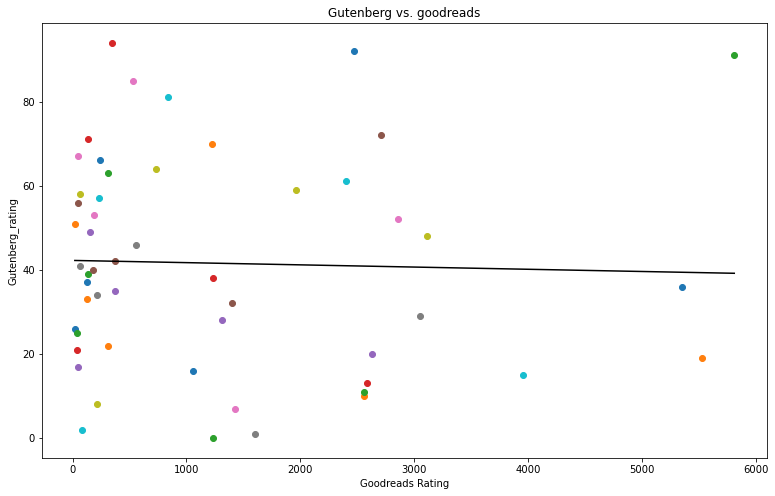

In [19]:
finaldf1 = finaldf.copy()
finaldf1 = remove_outliers('goodreads_rating', finaldf1)
plot_rating('Gutenberg_rating', finaldf1)

It looks like there is a clustering of values near the 'lower' end of the goodreads rankings and the linear regression line suggests a slight negative correlation. Let's look at the [correlation coefficient](https://www.investopedia.com/terms/c/correlationcoefficient.asp) to see how strong the correlation between our goodreads ranking and project gutenberg's ranking. 

In [20]:
y_lst = finaldf1['Gutenberg_rating'].astype(str).astype(float)
x_lst = finaldf1['goodreads_rating'].astype(str).astype(float)
cor_coef = x_lst.corr(y_lst)
print(cor_coef)

-0.03155530133993916


From now on we will just refer to the correlation coefficient as "r". Any r between (-0.1,0.1) is generally considered to show no correlation. With such a low correlation coefficient we can assume that our current ranking system yields no correlation.

## Using a different measurement
We've found our original measurement to not be great at predicting the books that will be popular on Project Gutenberg. Instead of giving up lets try using a different measurement. Let's just try using the ratings_count of each book on goodreads because it seems the most like that of gutenberg downloads. Someone may have given a book on goodreads a negative review but that still means they(probably read it). This is similar to people downloading from project gutenberg, they downloaded the book but they may have not enjoyed it.

In [21]:
#Sort the dataframe by the ratings_count from goodreads
grdf = grdf.sort_values(by=['ratings_count'], ascending=False)
#This will reset the indexing of the dataframe so that index 0 is the highest ranking
grdf = grdf.reset_index()
#Cleans up the old indexing
grdf = grdf.drop('index', axis=1)

In [22]:
#ranks the books in finaldf2 to our new ranking system
for index, row in finaldf.iterrows():
    gu = finaldf.loc[index, 'Gutenberg_rating']
    i = grdf[grdf['Gutenberg_rating']==gu].index.values
    if i:
        finaldf.at[index, 'goodreads_rating'] = i[0]
finaldf2 = finaldf.copy()

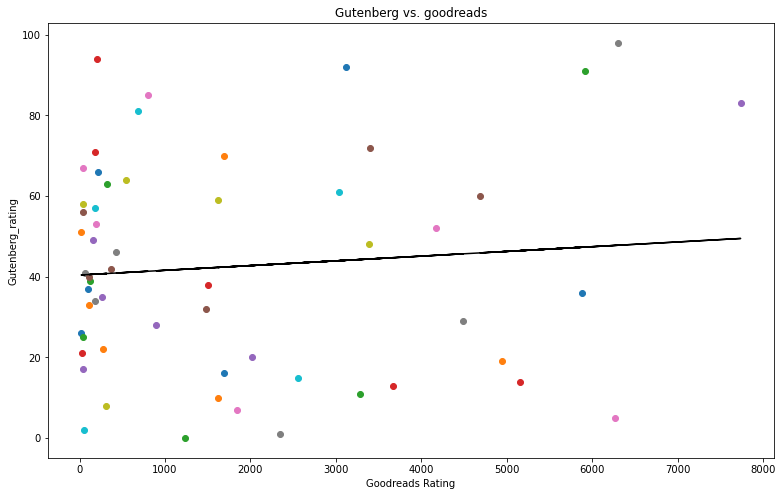

In [23]:
finaldf2 = remove_outliers('goodreads_rating', finaldf2)
plot_rating('Gutenberg_rating', finaldf2)

At first glance this graph looks generally a lot like the previous one. Let's check that by looking at the correlation coefficient.

In [24]:
y_lst = finaldf2['Gutenberg_rating'].astype(str).astype(float)
x_lst = finaldf2['goodreads_rating'].astype(str).astype(float)
cor_coef = x_lst.corr(y_lst)
print(cor_coef)

0.09163499626466973


Our previous r was approximately -0.03 and this is approximately 0.09. An absolute increase of about 0.06. This is relatively large and leads me to believe that using the average rating of a book to find a book suitable for project gutenberg is detrimental to finding a book that is best fit. That being said, both of these values are still within the (-0.1,0.1) range so we still don't have any significant correlation.

## Another measurement
It seems like using only the number of book ratings on goodreads has more relation to project gutenberg, let's try comparing project gutenberg downloads to the number of book ratings on goodreads.

In [25]:
finaldf3 = finaldf.copy()
finaldf3 = remove_outliers('goodreads_rating', finaldf3)
finaldf3 = remove_outliers('downloads', finaldf3)

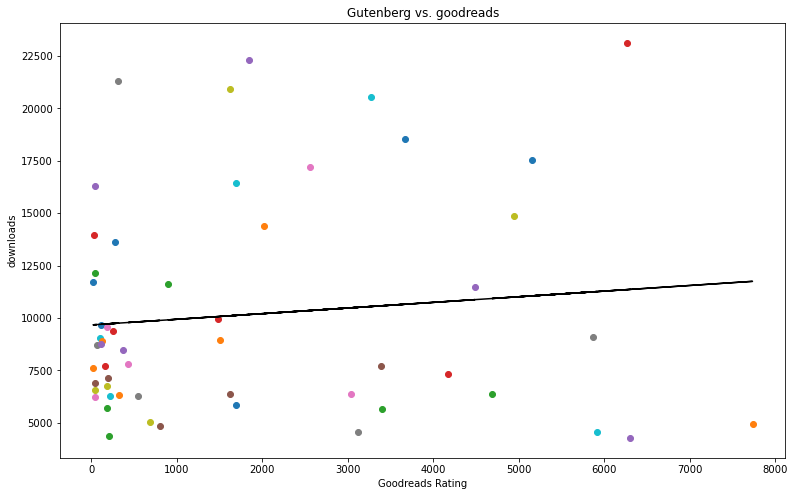

In [26]:
plot_rating('downloads', finaldf3)

Now this graph is a bit deceptive. Remember that the closer a book is to zero in the goodreads rating, the more popular it is, so this graph suggests that the less popular books on goodreads have more downloads on project gutenberg. This is a bit odd so let's look at the statistics to verify this conclusion.

In [27]:
y_lst = finaldf3['downloads']
x_lst = finaldf3['goodreads_rating'].astype(str).astype(float)
cor_coef = x_lst.corr(y_lst)
print(cor_coef)

0.10944465546575988


The correlation coefficient is more than 0.1 so lets see how likely it is that we would have gotten this statistic from the test data by performing a hypothesis [t-test](https://online.stat.psu.edu/stat501/lesson/1/1.9) on r with a significance level of 0.05.

In [29]:
from math import sqrt
from scipy import stats
n = len(finaldf3.index)
degrees_freedom = n-2
t = (cor_coef*(sqrt(degrees_freedom)))/(sqrt(1-(cor_coef**2)))
#the following line of code is from the scipy docs
#https://docs.scipy.org/doc/scipy/reference/tutorial/stats.html
pval = stats.t.sf(np.abs(t), n-1)*2
print('t-statistic = %6.3f pvalue = %6.4f' % (t, pval))
if (pval < 0.05):
    print('Reject Null Hypothesis')
else:
    print('Fail to Reject Null Hypothesis')

t-statistic =  0.802 pvalue = 0.4263
Fail to Reject Null Hypothesis


We haven't found any statistically supportable correlation between the popularity of books from goodreads and project gutenberg, meaning that we can't create a machine learning prediction model for a relationship we can't verify exists.

# Conclusion
We have compared the data from goodreads and the data from project gutenberg using multiple different measurements and each time we have failed to reject the null hypothesis that there is no relation between the popularity of books on goodreads and the popularity of books on project gutenberg. Only one measurement gave us a correlation coefficient with an absolute value more than 0.1 and that value was only barely more, suggesting that there was only a very weak correlation between the popularity of books on each site. Furthermore, we ended up discovering that this correlation coefficient was well above our significance level of 5%  meaning that there isn't enough evidence at the 5% significance level to conclude that there is a linear relationship between the popularity of a book on goodreads and the popularity of a book on project gutenberg. This all comes together to form the conclusion that we cannot use goodreads data to find books to add to project gutenberg that would be preferred by their user base.

Our inability to find a linear relationship is probably due to two things. Firstly it is likely that goodreads and project gutenberg have a different reader base. This can be seen in the fact that 22 books from the top 100 from project gutenberg don't have authors found on goodreads and 16 have authors found on goodreads but the books themselves were not found. Furthermore, the top 100 books on project gutenberg contain a lot of philosophy(Nietzsche, Plato, John Locke) and I would be surprised if the average reader was so heavily into philosophy that they would read that much of it.

The second reason is that our project gutenberg sample isn't the best sample. It introduces bias because it is the top 100 books and therefore, may not be representative of the whole database. Additionally, this sample size is too small. A good sample size is around 10% of the population size up to 1000. Project gutenberg has tens of thousands of books so a good sample size is 1000 but we only used 100. If I were to do this project over again, I would use [this](https://www.gutenberg.org/ebooks/search/?sort_order=downloads) as my project gutenberg dataset. It still has bias but is a much larger sample, even if navigating through it while scraping it would be a nightmare.